In [29]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision

In [20]:
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else
                      "cpu")
device

device(type='mps')

In [22]:
# 훈련(train) 데이터에는 데이터 증강 및 정규화를 적용
# 검증(val) 데이터에는 정규화만 적용
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),      # 1. 무작위로 이미지를 224x224 크기로 자르기 (데이터 증강)
        transforms.RandomHorizontalFlip(),      # 2. 50% 확률로 이미지를 좌우 반전시키기 (데이터 증강)
        transforms.ToTensor(),                  # 3. 이미지를 PyTorch 텐서로 변환하기.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 4. 이미지 정규화
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),                 # 1. 이미지 크기를 256으로 조절하기.
        transforms.CenterCrop(224),             # 2. 이미지 중앙을 224x224 크기로 자르기.
        transforms.ToTensor(),                  # 3. 텐서로 변환
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 4. 정규화
    ]),
}

# 데이터 경로를 설정.
data_dir = "./hymenoptera_data"

# ImageFolder를 사용해 데이터를 불러오기.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# DataLoader를 사용해 미니배치로 만들 준비
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=2) # batch_size=8, num_workers=2로 설정
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

Dataset sizes: {'train': 244, 'val': 153}
Class names: ['ants', 'bees']


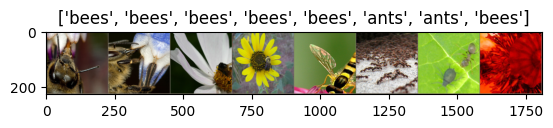

In [23]:
def imshow(inp, title=None):
    """텐서를 이미지로 보여주는 함수"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# 학습 데이터에서 이미지 한 배치를 가져와서 그리기
inputs, classes_idx = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes_idx])

In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            # MPS 에러를 해결하기 위해 .double()을 .float()로 수정
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model



In [8]:
# 미리 학습된 ResNet-18 모델 불러오기
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
# 마지막 분류 레이어를 클래스 수에 맞게 수정
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# --- 모델 학습 시작 ---
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.3738 Acc: 0.8234
val Loss: 0.1233 Acc: 0.9750

Epoch 2/10
----------
train Loss: 0.2820 Acc: 0.8822
val Loss: 0.1298 Acc: 0.9700

Epoch 3/10
----------
train Loss: 0.2794 Acc: 0.8832
val Loss: 0.1687 Acc: 0.9550

Epoch 4/10
----------
train Loss: 0.2718 Acc: 0.8932
val Loss: 0.2020 Acc: 0.9600

Epoch 5/10
----------
train Loss: 0.2199 Acc: 0.9042
val Loss: 0.1320 Acc: 0.9650

Epoch 6/10
----------
train Loss: 0.2409 Acc: 0.9032
val Loss: 0.1398 Acc: 0.9650

Epoch 7/10
----------
train Loss: 0.1864 Acc: 0.9182
val Loss: 0.1327 Acc: 0.9800

Epoch 8/10
----------
train Loss: 0.2012 Acc: 0.9162
val Loss: 0.1376 Acc: 0.9800

Epoch 9/10
----------
train Loss: 0.1822 Acc: 0.9152
val Loss: 0.1262 Acc: 0.9750

Epoch 10/10
----------
train Loss: 0.1390 Acc: 0.9401
val Loss: 0.1432 Acc: 0.9600

Training complete in 4m 25s
Best val Acc: 0.980000


In [25]:
# 1. 미리 학습된 EfficientNet-B0 모델 불러오기
model_eff = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# 2. EfficientNet의 마지막 분류기 구조 확인 및 수정
# EfficientNet은 마지막 레이어가 model.classifier[1]에 있습니다.
num_ftrs = model_eff.classifier[1].in_features
model_eff.classifier[1] = nn.Linear(num_ftrs, len(class_names))

# 3. 모델을 MPS 장치로 이동
model_eff = model_eff.to(device)

# 4. 손실 함수, 옵티마이저, 스케줄러 설정
criterion = nn.CrossEntropyLoss()
optimizer_eff = optim.SGD(model_eff.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_eff, step_size=7, gamma=0.1)

# 5. 모델 학습 시작!
model_eff = train_model(model_eff, criterion, optimizer_eff, exp_lr_scheduler, num_epochs=15)

Epoch 1/15
----------
train Loss: 0.6411 Acc: 0.6230
val Loss: 0.4761 Acc: 0.8497

Epoch 2/15
----------
train Loss: 0.4759 Acc: 0.8320
val Loss: 0.3394 Acc: 0.9281

Epoch 3/15
----------
train Loss: 0.4016 Acc: 0.8730
val Loss: 0.2644 Acc: 0.9281

Epoch 4/15
----------
train Loss: 0.3467 Acc: 0.8730
val Loss: 0.2293 Acc: 0.9281

Epoch 5/15
----------
train Loss: 0.3069 Acc: 0.8811
val Loss: 0.1957 Acc: 0.9412

Epoch 6/15
----------
train Loss: 0.2602 Acc: 0.9098
val Loss: 0.1771 Acc: 0.9477

Epoch 7/15
----------
train Loss: 0.2918 Acc: 0.8730
val Loss: 0.1698 Acc: 0.9412

Epoch 8/15
----------
train Loss: 0.2238 Acc: 0.9180
val Loss: 0.1828 Acc: 0.9412

Epoch 9/15
----------
train Loss: 0.2819 Acc: 0.8975
val Loss: 0.1734 Acc: 0.9346

Epoch 10/15
----------
train Loss: 0.2238 Acc: 0.9344
val Loss: 0.1812 Acc: 0.9281

Epoch 11/15
----------
train Loss: 0.2404 Acc: 0.9057
val Loss: 0.1841 Acc: 0.9085

Epoch 12/15
----------
train Loss: 0.2097 Acc: 0.9221
val Loss: 0.1694 Acc: 0.9346

E

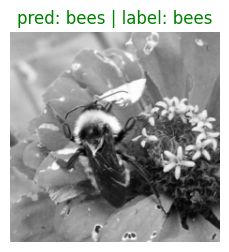

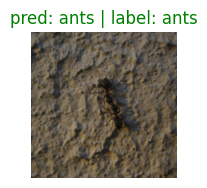

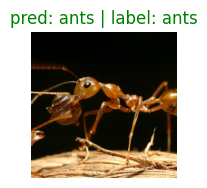

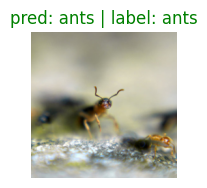

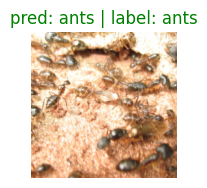

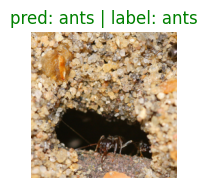

<Figure size 640x480 with 0 Axes>

In [32]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(12, 6))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                # subplot 위치를 올바르게 계산
                ax = plt.subplot(num_images // 3, 3, images_so_far)
                ax.axis('off')

                # 예측 결과에 따라 제목 색상 변경
                title_text = f"pred: {class_names[preds[j]]} | label: {class_names[labels[j]]}"
                color = "green" if preds[j] == labels[j] else "red"
                ax.set_title(title_text, color=color)

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    # 전체 그림을 한 번에 보여줌
                    plt.tight_layout()
                    plt.show()
                    return
        model.train(mode=was_training)

visualize_model(model_eff, num_images=6) # 6개의 이미지로 확인

In [38]:
from PIL import Image

In [39]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

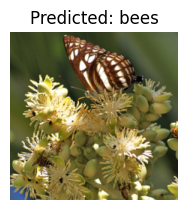

In [40]:
visualize_model_predictions(
    model_eff,
    img_path='./hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()